# MANUAL DE LABORATORIO DE COMUNICACIONES DIGITALES: PYTHON
F. Javier Payán Somet, Juan José Murillo-Fuentes, José Carlos Aradillas Jaramillo \
_Departamento de Teoría de la Señal y Comunicaciones_ \
_Escuela Técnica Superior de Ingeniería_ \
_Universidad de Sevilla_ 

# Tema 6. Demodulador óptimo en un canal AWGN

**Este notebook contiene código del Tema 6**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/gapsc-us/labcomdig/blob/main/Tema6.Demodulador_Canal_AWGN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Inicialización

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Numpy ≥1.16 is required
import numpy as np
assert np.__version__ >= "1.16"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore") #Ignorar warnings

## Diseño experimental

### Simulación de un canal AWGN discreto

**Código 6.1** Salida del receptor vectorial en un canal AWGN para una PAM.

Las funciones que se describen aquí están en el fichero labcomdig.py y se definieron en temas anteriores

In [2]:
def transmisorpam(Bn,Eb,M,p,L):
    '''
    [Xn,Bn,An,phi,alfabetopam] = transmisorpam(Bn,Eb,M,p,L) 
    
    Entradas:    
     Bn = Secuencia de dígitos binarios
     Eb = Energía media por bit transmitida en Julios
     M  = Número de síímbolos del código PAM
     p  = Pulso paso de baja o paso de banda 
     L  = Número de puntos a utilizar en la representación de un símbolo
    
    Devuelve:
     Xn = la señal de información (discreta)
     Bn = La secuencia de dígitos binarios realmente transmitidos
     An = La secuencia de niveles de amplitud transmitidos
   	 phi = Pulso básico real normalizado (energía unidad)
     alfabetopam = Los niveles de amplitud asociados a cada símbolo
    '''    
    
    #Comprobación de parámetros de entrada
    p=p.squeeze()
    if len(Bn)<1 or Eb<=0 or M<2 or p@p==0 or L<1:
        raise Exception('Error: revise los parámetros de entrada')
    
    # Se obtienen en primer lugar los niveles asociado a cada símbolo ¿Cuántos bits hay en cada sí­mbolo?
    k = int(np.ceil(np.log2(M)))   
    M = 2**(k) # Se Ajusta M a una potencia de dos
    
    # El alfabeto [Ver la ecuación (4.21)] 
    alfabetopam = np.sqrt(3*Eb*np.log2(M)/(M**2-1))*(2*(np.arange(M))-M+1)
    
    # Si Bn no tiene una longitud múltiplo de k, se completa con ceros
    Nb = len(Bn)  # Número de bits a transmitir, actualizado
    Bn = Bn.squeeze().astype(int) #Comprobación de int y dimensiones   
    Bn = np.r_[Bn,np.zeros(int(k*np.ceil(Nb/k)-Nb)).astype(int)] #
    Nb = len(Bn)  # Número de bits a transmitir tras la corrección
    Ns = Nb//k # Número de símbolos a transmitir
    
    # La secuencia generada
    if M>2:
        An = alfabetopam[gray2de(np.reshape(Bn,[Ns,k]))]
    else:
        An = alfabetopam[Bn]
    
    # Comprobación de las longitudes y otros datos del pulso suministrado para 
    # hacer que el número de muestras del mismo sea efectivamente L
    Ls = len(p)
    if Ls<L:
        p = np.r_[p, np.zeros(L-Ls)]
    elif Ls>L:
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))
        p = p[:L] #Debe modificarse si se quiere un pulso de más de L muestras 
    # Se normaliza la energía del pulso para obtener la base del sistema
    phi = p / np.sqrt(p@p) 
       
    # Obtención del tren de pulsos, Xn = np.kron(An,phi) ó
    Xn = np.reshape(np.reshape(An,[Ns,1])*phi,[Ns*L,]) #Debe modificarse si se quiere un pulso de más de L muestras
    return [Xn,Bn,An,phi,alfabetopam]

Se necesita la siguiente función, del notebook anterior:

In [3]:
def gray2de(b):
    '''
    Convierte cada columna de la matriz formada por dígitos binarios b en un vector
        fila de los valores decimales correspondientes, aplicando codificación de Gray.
    '''
    if not isinstance(b, (np.ndarray, list, tuple)):  # se comprueba que no sea np.array, lista o tupla
       raise Exception('Error: la entrada no es un array, lista o tupla')
    b = np.array(b)    # Esto es para que admita también listas y tuplas
    c = np.zeros_like(b); c[:,0] = b[:,0]
    for i in range(1,np.shape(b)[1]):
        c[:,i] = np.logical_xor(c[:,i-1], b[:,i])
    c = np.fliplr(c) # Convierte los bits menos significativos en los más significativos
    #Comprueba un caso especial.
    [n,m] = np.shape(c) 
    if np.min([m,n]) < 1:
        d = []
        return
    d = c @ 2**np.arange(m)
    return d 

y

In [4]:
def split(Bn, M1, M2):
    '''
    Entradas
        Bn = una secuencia de símbolos binarios
        M1 = nº de símbolos de la componente en fase
        M2 = nº de símbolos de la componente en cuadratura    
    Salida     
        Bn = una secuencia de símbolos binarios
        M1 = nº de símbolos de la componente en fase
        M2 = nº de símbolos de la componente en cuadratura
    '''
    
    k1 = int(np.log2(M1))
    k2 = int(np.log2(M2))
    k = k1 + k2
    
    #Longitud de la secuencia
    Nb = len(Bn)
    
    #Una matriz con Ns=Nb/k filas formadas por los k bits
    W = np.reshape(Bn,[int(Nb/k),k])
    
    #Extrae la submatriz formada por los k1 primeros bits y pone una fila tras otra
    BnI = np.reshape(W[:,:k1],[k1*int(Nb/k)])
    
    #Extrae la submatriz formada por los k2 bits restantes y pone una fila tras otra
    BnQ = np.reshape(W[:,k1:],[k2*int(Nb/k)]) 
    
    return BnI, BnQ

**Código 6.1** Salida del receptor vectorial en un canal AWGN para una PAM.

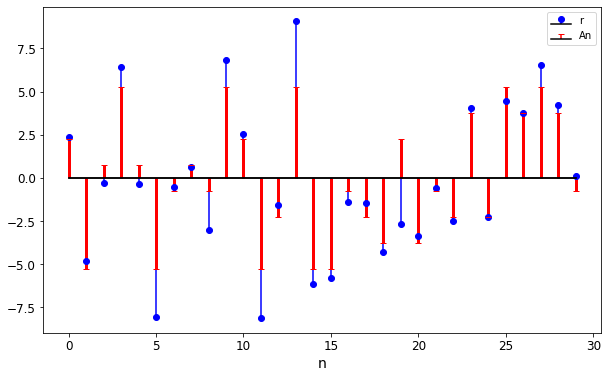

In [5]:
np.random.seed(76) #To get same results

#%% Transmisor
M = 8 #Tamaño de la constalación
Eb = 4 # Energía por bit transmitida
L = 4 #N. de muestras por símbolo
Nb = 10**4 #N. de bits a transmitir
p = np.ones(L)
Bn = np.random.randint(2, size = Nb)
[Xn, Bn, An, phi, alfabeto] = transmisorpam(Bn,Eb,M,p,L)

#%% Canal 
SNRdb = 0
SNR = 10**(SNRdb/10) #paso a unidades naturales
varzn = Eb/(2*SNR) #Cálculo de la varianza del ruido
Wn = np.sqrt(varzn)*np.random.randn(len(Xn)) #Muestras de ruido, del canal
rn = Xn + Wn  #Salida del canal, entrada al receptor vectorial

#%% Receptor Vectorial
M = len(alfabeto)  #Símbolos de la constelación M-PAM
Nb = len(Bn)  #Número de bits transmitidos
Ns = int(Nb/np.log2(M))   #Nçumero d esímbolos transmitidos

# Mediante filtro adaptado
hr = np.flipud(phi)
yn = np.convolve(hr, rn, 'valid')
r = yn[np.arange(0,Ns*L,L)]  #Salida del receptor vectorial

# Mediante correlador
r = np.reshape(rn,[Ns,L]) @ phi  #Salida del receptor vectorial

#%% Representación de resultados
plt.figure(1, figsize=(10,6))
plt.stem(r[:30],linefmt='b-',markerfmt='bo',basefmt='k-',use_line_collection = True)
plt.xlabel('n')
markerline, stemlines, baseline = plt.stem(An[:30],linefmt='r-',markerfmt='r_',basefmt='k-',use_line_collection = True)
plt.setp(stemlines, 'linewidth', 3)
plt.legend(['r','An'])

## Constelación recibida

### Constelación mediante un banco de correladores



Rescatamos la siguiente función, al igual que las anteriores contenida en labdomdig.py

In [6]:
def transmisorqam(Bn, Eb, M1, M2, p1, p2, L): 
    '''
    [Xn,BnI,BnQ,AnI,AnQ,AI,AQ,phi1,phi2] = transmisorqam(Bn, Eb, M1, M2,p1,p2,L)
    
    Entradas:
     Bn = Secuencia de dígitos binarios
     Eb = Energía media por bit transmitida en Julios
     M1 = Nº de símbolos de la componente en fase
     M2 = Nº de símbolos de la componente en cuadratura
     p1 = Pulso real de la componente en fase
     p2 = Pulso real de la componente en cuadratura
     L = Nº de puntos que vamos a utilizar en la representación un símbolo
        
    Devuelve:
     Xn = la señal de información digital
     BnI = Bits transmitidos por la componente en fase
     BnQ = Bits transmitidos por la componente en cuadratura
     AnI = Niveles de amplitud transmitidos por la componente en fase
     AnQ = Niveles de amplitud transmitidos por la componente en cuadratura 
     AI = Niveles de amplitud usados en la componente en fase
     AQ = Niveles de amplitud usados en la componente en cuadratura
     phi1 = Pulso básico normalizado (energí­a unidad) de la componente en fase
     phi2 = Pulso básico normalizado (energí­a unidad) de la componente en cuadratura 
    '''
    #Comprobación de parámetros de entrada
    p1 = p1.squeeze()
    p2 = p2.squeeze()
    if len(Bn)<1 or Eb<=0 or M1<2 or M2<2  or p1@p1==0 or p2@p2==0 or L<1:
       raise Exception('Error: revise los parámetros de entrada')    
       
    #Definiciones
    eps = np.finfo(float).eps # por debajo de este valor se considera cero
    
    #Comprobación de los pulsos básicos
    Ls1 = len(p1)
    Ls2 = len(p2)
    if Ls1<L:
        p1 = np.r_[p1, np.zeros(int(L-Ls1))]
    elif Ls1>L:
        p1 = p1[:L]
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))
    if Ls2<L:
        p2 = np.r_[p2, np.zeros(int(L-Ls2))]
    elif Ls1>L:
        p2 = p2[:L]
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))       

    #Normalicemos las energías de los pulsos
    phi1 = 1/np.sqrt(p1@p1)*p1
    phi2 = 1/np.sqrt(p2@p2)*p2
    
    #Comprobemos la ortogonalidad
    if np.abs(phi1@phi2) >= 1e2*eps:
        raise Exception('Bases no ortogonales, no es posible realizar la transmisión')
    
    #Ajuste de los parámetros   
    k1 = int(np.ceil(np.log2(M1))) #Número de bits de la componente en fase
    M1 = 2**(k1) #Valor de M1 tras la corrección
    k2 = int(np.ceil(np.log2(M2))) #Número de bist de la componente en cuadratura M2 = 2**(k2) #Valor de M2 tras la corrección
    k = k1 + k2 #Número de bits en cada símbolo QAM
    Nb = len(Bn); Bn = Bn.squeeze().astype(int) #Comprobación de int y dimensiones
    Bn = np.r_[Bn,np.zeros(int(k*np.ceil(Nb/k)-Nb)).astype(int)]    
    
    #Obtención de la mitad de la distancia mínima entre símbolos para Eb dada
    A = np.sqrt(3*Eb*np.log2(M1*M2)/(M1**2+M2**2-2))
    
    #El alfabeto con los niveles
    AI = A * (2*np.arange(M1)-M1+1)
    AQ = A * (2*np.arange(M2)-M2+1)
    
    #Separación de la secuencia de bits en las secuencias de las componentes en fase y cuadratura
    BnI,BnQ = split(Bn,M1,M2)
    NbI = len(BnI)
    NbQ = len(BnQ)
    
    #Obtención de la secuencia de símbolos de las componentes en fase y cuadratura
    if M1>2:
        AnI = AI[gray2de(np.reshape(BnI,[int(NbI/k1),k1]))] 
    else:
        AnI = AI[BnI]
    if M2>2:
        AnQ = AQ[gray2de(np.reshape(BnQ,[int(NbQ/k2),k2]))]
    else:
        AnQ = AQ[BnQ]
    Ns = len(AnI)    
    
    #Las componentes en fase, cuadratura y total de la señal discreta a transmitir
    XnI=np.reshape(np.reshape(AnI,[Ns,1])*phi1,[Ns*L,]) #ó XnI=np.kron(AnI, phi1);
    XnQ=np.reshape(np.reshape(AnQ,[Ns,1])*phi2,[Ns*L,]) #ó XnQ=np.kron(AnQ, phi2);
    Xn = XnI+XnQ;
    return Xn, BnI, BnQ, AnI, AnQ, AI, AQ, phi1, phi2 


**Código 6.2** Constelación de un sistema QAM rectangular paso de baja.

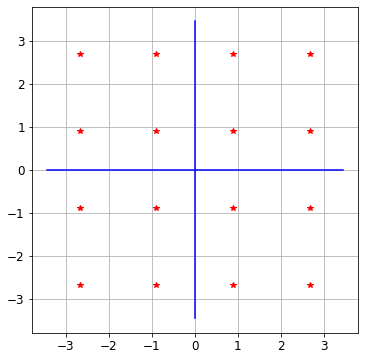

In [7]:
# Datos
Bn = np.random.randint(2, size=10**4)
Eb = 2
L = 4
M1 = 4
M2 = 4

#%% Definición de los pulsos básicos
p1 = np.r_[np.ones(int(L/2)), np.zeros(int(L/2))] 
p2 = np.r_[np.zeros(int(L/2)), np.ones(int(L/2))]

#%% Transmisor: obtención de la señal QAM
[Xn,BnI,BnQ,AnI,AnQ,AI,AQ,phi1,phi2] = transmisorqam(Bn,Eb,M1,M2,p1,p2,L)

#%% Obtengamos los parámetros necesarios para la representación tras las posibles modificaciones
L = len(phi1)                       #Número de muestras por sí­mbolo
Ns = int((len(BnI)+len(BnQ))/(np.log2(len(AI)*len(AQ))))	#Nº de sí­mbolos transmitidos

#%% Receptor vectorial: obtención de las secuencias de niveles transmitidos
#El canal es perfecto, a su salida se tiene una copia de la entrada
#sn = np.dot(np.reshape(Xn,[Ns,L]),np.c_[phi1,phi2])
sn = np.reshape(Xn,[Ns,L]) @ np.c_[phi1,phi2]
sn1 = sn[:,0]
sn2 = sn[:,1]

#%% Extraemos la constellación de los valores recibidos
s1 = np.unique(np.single(sn1))  #Valores distintos encontrados en An1
xmax = max(s1)+max(s1)/10+0.5
xmin = -(abs(min(s1))+abs(min(s1))/10)-0.5

s2 = np.unique(np.single(sn2))  #Valores distintos encontrados en An2
ymax = np.max(s2)+np.max(s2)/10+0.5
ymin = -(np.abs(np.min(s2))+np.abs(np.min(s2))/10)-0.5

#%% Se representa la constellación
plt.figure(61,figsize=(6,6))
# Representa los ejes
plt.plot([xmin,xmax],[0,0],'b-')
plt.plot([0,0],[ymin,ymax],'b-')
#Representa la constelación
for ii in range(len(s1)):
    for jj in range(len(s2)):
        plt.plot(s1[ii],s2[jj], 'r*')
plt.axis('square')
plt.grid()

 ### Constelación mediante filtros adaptados
 
 Usamos la función ya definida en el tema anterior

In [8]:
def transmisorpsk(Bn,Eb,M,p1,p2,L): 
    '''
    [Xn,Bn,An,phi1,phi2,alfabeto] = transmisorpsk(Bn,Eb,M,p1,p2,L)
   
    Entradas:
    Bn = Secuencia de dígitos binarios
    Eb = Energía media por bit transmitida en Julios
    M = Número de símbolos del código PSK
    p1 = Pulso real de la componente en fase
    p2 = Pulso real de la componente en cuadratura
    L = Número de puntos que se utilizará en la representación de un símbolo
    
    Devuelve:
    Xn = la señal de información discreta
    Bn = La secuencia de dígitos binarios realmente transmitidos
    An = La secuencia de símbolos complejos transmitidos
    phi1 = Pulso básico real normalizado (energí­a unidad) de la componente en fase
    phi2 = Pulso básico real normalizado (energí­a unidad) de la componente en cuadratura
    alfabeto = El alfabeto utilizado asociado a cada símbolo transmitido
    '''
    #Comprobación de parámetros de entrada
    p1 = p1.squeeze(); p2 = p2.squeeze()
    if len(Bn)<1 or Eb<=0 or M<2 or p1@p1==0 or p2@p2==0 or L<1:
       raise Exception('Error: revise los parámetros de entrada')
        
    #Definiciones
    eps = np.finfo(float).eps # por debajo de este valor se considera cero
      
    # Comprobación de las longitudes y otros datos de los pulsos de llamada
    Ls1 = len(p1)
    Ls2 = len(p2)
    if Ls1==0 or Ls2==0:
        print('No es posible realizar la transmisión') 
        return
   
    if Ls1<L:
        p1 = np.r_[p1, np.zeros(int(L-Ls1))]
    elif Ls1>L:
        p1 = p1[:L]
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))
    if Ls2<L:
        p2 = np.r_[p2, np.zeros(int(L-Ls2))]
    elif Ls2>L:
        p2 = p2[:L]
        print('La duración del pulso se trunca a {} muestras'.format(str(L)))       
       
    # Se comprueba la ortogonalidad
    if abs(p1@p2) >= 1e0*eps*10:
        print('No es posible realizar la transmisión') 
        return
       
    # Se normalizan las energías de los pulsos
    phi1 = p1 / np.sqrt(p1@p1) 
    phi2 = p2 / np.sqrt(p2@p2)  
    # Se genera el pulso complejo [Ver la ecuación (5.25)]
    phi = phi1 - 1j*phi2
   
    # Obtención de los niveles asociados a cada símbolo: alfabeto
    # Número de bits por símbolo
    k = int(np.ceil(np.log2(M)))
    # Se ajusta M a una potencia de dos
    M = 2**(k)
    # El alfabeto [Ver la ecuación (5.24)]
    alfabeto = np.sqrt(Eb*k)*np.exp(1j*2*np.pi*np.arange(M)/M) #empieza en 0
   
    # Si la longitud de Bn no es múltiplo de k, se completa con ceros
    Nb = len(Bn) 
    Bn = np.r_[Bn,np.zeros(int(k*np.ceil(Nb/k)-Nb)).astype(int)] #
   
    # Número de bits y símbolos que vamos a transmitir
    Nb = len(Bn) # Número de bits que vamos a transmitir tras la corrección 
    Ns = int(Nb/k)

    # La secuencia generada
    if M>2:
         An = alfabeto[gray2de(np.reshape(Bn,[Ns,k]))]
    else:
        An = alfabeto[Bn]
    
    # Obtención del tren de pulsos,    Xn = np.real(np.kron(An, phi))  ó
    Xn = np.real(np.reshape(np.reshape(An,[Ns,1])*phi,[Ns*L,]))
    return [Xn, Bn, An, phi1, phi2, alfabeto] 


 **Código 6.3** Constelación de un sistema M-PSK paso de baja mediante filtros adaptados.

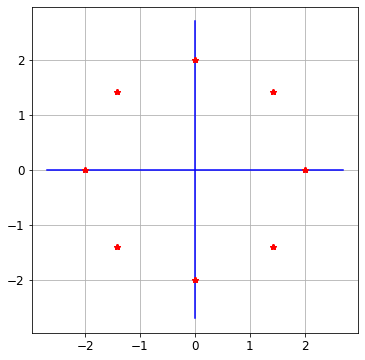

In [9]:
#%% Datos
Bn = np.random.randint(2, size=10**4)
Eb = 4/3
L = 8
M = 8

#%% Definición de los pulsos básicos
p1 = np.r_[np.ones(int(L/2)), np.zeros(int(L/2))] 
p2 = np.r_[np.zeros(int(L/2)), np.ones(int(L/2))] 

#%% Transmisor: Generación de la señal M-PSK
[Xn,Bn,An,phi1,phi2,alfabeto] = transmisorpsk(Bn,Eb,M,p1, p2, L);
k = np.log2(len(alfabeto))
L = len(phi1)     #Número de muestras por símbolo
Ns = int(len(Bn)/k)  #Nº de símbolos transmitidos

#%% Receptor Vectorial con filtros adaptados
hr1 = np.flipud(phi1)
hr2 = np.flipud(phi2)

yn1 = np.convolve(hr1,Xn, 'valid')
yn2 = np.convolve(hr2,Xn, 'valid')

# Señal de salida
sn1 = yn1[np.arange(0,Ns*L,L)]          
sn2 = yn2[np.arange(0,Ns*L,L)]   
      
#%% Representación: 
# Obtiene valores máximos y mínimos para la representación
xmax = max(sn1) + max(sn1)/10 + 0.5
xmin = -(abs(min(sn1)) + abs(min(sn1))/10) - 0.5
ymax = max(sn2) + max(sn2)/10 + 0.5
ymin = -(abs(np.min(sn2))+abs(min(sn2))/10) - 0.5

plt.figure(62,figsize=(6,6))
# Pinta los ejes
plt.plot([xmin,xmax],[0,0],'b-')
#hold
plt.plot([0,0],[ymin,ymax],'b-')

# Representa
Nmax = int(min(64,len(Bn)/k))
plt.plot(sn1[:Nmax],sn2[:Nmax], 'r*')
plt.axis('square')
plt.grid()

## Scattering plot del vector de observación
**Código 6.4** Scattering plot de un sistema QAM rectangular.

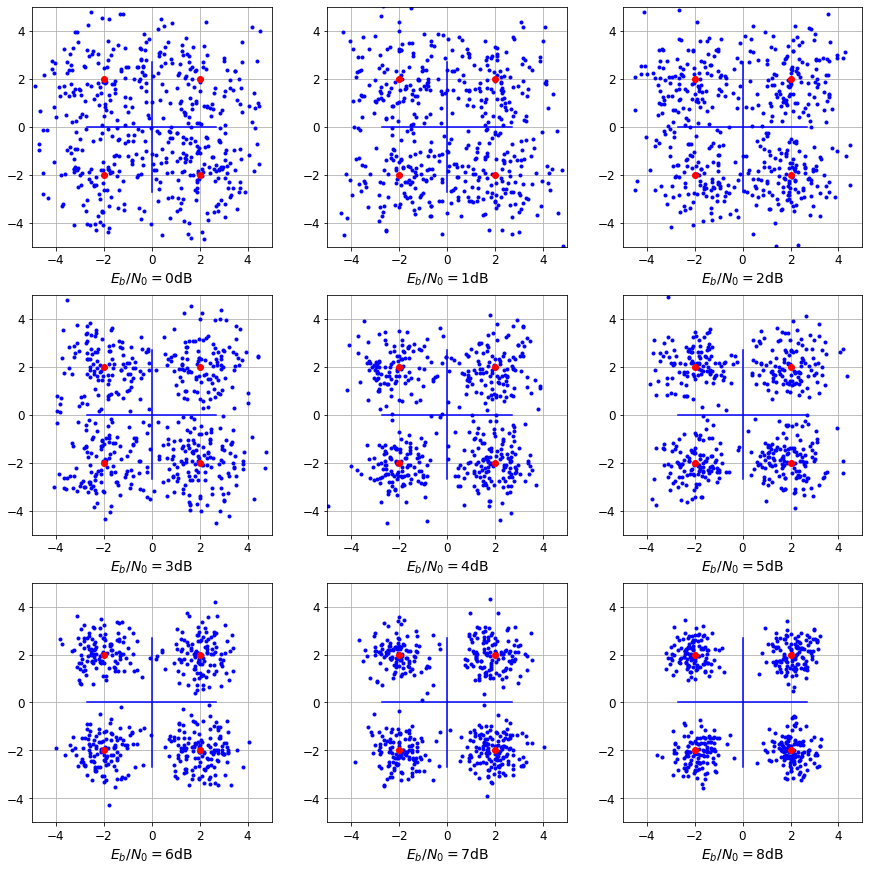

In [10]:
# Datos
Bn = np.random.randint(2, size=10**3)
Eb = 4
L = 4
M1 = 2
M2 = 2

#%% Transmisor. Definición de los pulsos básicos
p1 = np.r_[np.ones(int(L/2)), np.zeros(int(L/2))] 
p2 = np.r_[np.zeros(int(L/2)), np.ones(int(L/2))] 

# Obtención de la señal QAM
[Xn,BnI,BnQ,AnI,AnQ,AI,AQ,phi1,phi2] = transmisorqam(Bn,Eb,M1,M2,p1,p2,L)

# Obtengamos los parámetros necesarios para la representación tras las posibles modificaciones
L = len(phi1);                       #Número de muestras por sí­mbolo
Ns = int((len(BnI)+len(BnQ))/(np.log2(len(AI)*len(AQ))))  #Nº de sí­mbolos transmitidos

#%% Constelación en ausencia de ruido
sn = np.dot(np.reshape(Xn,[Ns,L]),np.c_[phi1,phi2])
sn1 = sn[:,0]
sn2 = sn[:,1]

# Obtiene los valores únicos
sx = np.unique(np.single(sn1))
xmax = max(sx)+max(sx)/10+0.5
xmin = -(abs(min(sx))+abs(min(sx))/10)-0.5

sy = np.unique(np.single(sn2))
ymax = max(sy)+max(sy)/10+0.5
ymin = -(abs(min(sy))+abs(min(sy))/10)-0.5

#%% Constellación (scattering) recibida para diversos valores de SNRdb
plt.figure(63, figsize=(15,15))
for SNRdB in range(9):  #SNR = 0,1,2,...,8  dB
    plt.subplot(3,3,SNRdB+1)
    # Representa los ejes
    plt.plot([xmin,xmax],[0,0],'b-')
    
    plt.plot([0,0],[ymin,ymax],'b-')
    plt.grid(), plt.axis('square')
    # Se obtiene varianza del ruido del canal
    
    SNR = 10**(SNRdB/10)  #SNR en unidades naturales
    varzn = Eb/(2*SNR)
    # Se obtienen muestras de ruido a sumar en el canal, se suman y se recuperan
    Wn = np.sqrt(varzn)*np.random.randn(np.size(Xn))
    r = np.reshape(Xn+Wn,[Ns,L]) @ np.c_[phi1,phi2] #Salida Rx Vectorial
    plt.plot(r[:,0], r[:,1], '.b')
    plt.axis([-5, 5, -5, 5])
    # Representa los valores obtenidos a la salida del receptor vectorial
    for ii in range(len(sx)):
        for jj in range(len(sy)):
            plt.plot(sx[ii],sy[jj], 'ro'); 
            plt.xlabel('$E_b/N_0=$' + str(SNRdB) + 'dB')
plt.tight_layout
plt.show()